In [148]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [149]:
df = pd.read_csv('./data/2019_opens_clean.csv')

## Data Cleaning

In [150]:
# just consider Men division
df = df[
    (df['division']=='Women') &
    (df['scaled_1']==0) &
    (df['scaled_2']==0) &
    (df['scaled_3']==0) &
    (df['scaled_4']==0) &
    (df['scaled_5']==0)
]
# drop column "Unnamed"
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

#### Scores dataframe

In [151]:
# dataframe without benchmarks or height & weight
scores_cols = ['competitorid', 'age', 'overallrank', \
               'time_2','time_3','time_4','time_5', \
               'w1_reps_total', \
               'w2_reps_total', 'w2_reps_t2b', 'w2_reps_du', \
               'w2_reps_sqcl', 'w2_rounds_completed', 'w2_tiebreak', \
               'w3_reps_total', 'w3_tiebreak', \
               'w4_reps_total', 'w4_reps_bmu', 'w4_tiebreak', \
               'w5_reps_total']
df_scores = df[scores_cols]

# drop rows with missing age values
df_scores = df_scores[df_scores['age'].notna()]
# keep just rows with all 5 workouts participated
df_scores = df_scores[df_scores['w1_reps_total'].notna()]
df_scores = df_scores[df_scores['w2_reps_total'].notna()]
df_scores = df_scores[df_scores['w3_reps_total'].notna()]
df_scores = df_scores[df_scores['w4_reps_total'].notna()]
df_scores = df_scores[df_scores['w5_reps_total'].notna()]
# drop rows with missing time values
df_scores = df_scores[df_scores['time_2'].notna()]
df_scores = df_scores[df_scores['time_3'].notna()]
df_scores = df_scores[df_scores['time_4'].notna()]
df_scores = df_scores[df_scores['time_5'].notna()]
# set missing tiebreak values to zero
df_scores['w2_tiebreak'].replace(np.NaN,0,inplace=True)
df_scores['w3_tiebreak'].replace(np.NaN,0,inplace=True)
df_scores['w4_tiebreak'].replace(np.NaN,0,inplace=True)

In [152]:
df_scores.shape

(29157, 20)

In [153]:
df_scores.to_csv('./data/rank_model_input_scores.csv')

#### + Benchmark dataframe

In [154]:
# dataframe with benchmark statistics inclusive
bs_cols = [
    'competitorid', 'age', 'overallrank', \
    'time_2','time_3','time_4','time_5', \
    'w1_reps_total', 'w2_reps_total', 'w2_reps_t2b', 'w2_reps_du', \
    'w2_reps_sqcl', 'w2_rounds_completed', 'w2_tiebreak', \
    'w3_reps_total', 'w3_tiebreak', \
    'w4_reps_total', 'w4_reps_bmu', 'w4_tiebreak', \
    'w5_reps_total', \
    'bs_backsquat', 'bs_cleanandjerk', 'bs_snatch', 'bs_deadlift', \
    'bs_fightgonebad', 'bs_maxpull_ups', 'bs_fran', 'bs_grace', 'bs_helen', \
    'bs_filthy50', 'bs_sprint400m', 'bs_run5k']
df_bs = df[bs_cols]

# keep just rows with all 5 workouts participated
df_bs = df_bs[df_bs['w1_reps_total'].notna()]
df_bs = df_bs[df_bs['w2_reps_total'].notna()]
df_bs = df_bs[df_bs['w3_reps_total'].notna()]
df_bs = df_bs[df_bs['w4_reps_total'].notna()]
df_bs = df_bs[df_bs['w5_reps_total'].notna()]

# set missing tiebreak values to zero
df_bs['w2_tiebreak'].replace(np.NaN,0,inplace=True)
df_bs['w3_tiebreak'].replace(np.NaN,0,inplace=True)
df_bs['w4_tiebreak'].replace(np.NaN,0,inplace=True)

# drop na
df_bs = df_bs.dropna()

In [155]:
df_bs.shape

(109, 32)

In [156]:
df_bs.to_csv('./data/rank_model_input_bs.csv')

## Data Preprocessing

#### Scores

In [157]:
# create train and test sets
train_set_sc, test_set_sc = train_test_split(df_scores, test_size=0.3, random_state=42)

# define target and features
y_sc = df_scores['overallrank']
X_sc = df_scores.drop(axis=1,columns='overallrank')

# train test split for model evaluation
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_sc, y_sc, random_state=42)

# define numerical features for scaling
scale_cols = ['competitorid','age','time_2','time_3', \
              'time_4', 'time_5', 'w1_reps_total', 'w2_reps_total', 'w2_reps_t2b', \
              'w2_reps_du', 'w2_reps_sqcl', 'w2_rounds_completed', 'w2_tiebreak', \
              'w3_reps_total', 'w3_tiebreak', 'w4_reps_total', 'w4_reps_bmu', \
              'w4_tiebreak', 'w5_reps_total'
             ]

# scaling numerical features
scaler = StandardScaler()
X_train_scaled_sc = scaler.fit_transform(X_train_sc[scale_cols])
X_test_scaled_sc = scaler.transform(X_test_sc[scale_cols])

X_train_preprocessed_sc = np.concatenate([X_train_scaled_sc, X_train_sc.drop(scale_cols, axis=1)], axis=1)
X_test_preprocessed_sc = np.concatenate([X_test_scaled_sc, X_test_sc.drop(scale_cols, axis=1)], axis=1)

#### benchmarks

In [158]:
# create train and test sets
train_set_bs, test_set_bs = train_test_split(df_bs, test_size=0.3, random_state=42)

# define target and features
y_bs = df_bs['overallrank']
X_bs = df_bs.drop(axis=1,columns='overallrank')

# train test split for model evaluation
X_train_bs, X_test_bs, y_train_bs, y_test_bs = train_test_split(X_bs, y_bs, random_state=42)

# define numerical features for scaling
scale_cols = [
    'competitorid','age','time_2','time_3', \
    'time_4', 'time_5', 'w1_reps_total', 'w2_reps_total', 'w2_reps_t2b', \
    'w2_reps_du', 'w2_reps_sqcl', 'w2_rounds_completed', 'w2_tiebreak', \
    'w3_reps_total', 'w3_tiebreak', 'w4_reps_total', 'w4_reps_bmu', \
    'w4_tiebreak', 'w5_reps_total', \
    'bs_backsquat', 'bs_cleanandjerk', 'bs_snatch', 'bs_deadlift', \
    'bs_fightgonebad', 'bs_maxpull_ups', 'bs_fran', 'bs_grace', \
    'bs_helen', 'bs_filthy50', 'bs_sprint400m', 'bs_run5k'
]

# scaling numerical features
scaler = StandardScaler()
X_train_scaled_bs = scaler.fit_transform(X_train_bs[scale_cols])
X_test_scaled_bs = scaler.transform(X_test_bs[scale_cols])

X_train_preprocessed_bs = np.concatenate([X_train_scaled_bs, X_train_bs.drop(scale_cols, axis=1)], axis=1)
X_test_preprocessed_bs = np.concatenate([X_test_scaled_bs, X_test_bs.drop(scale_cols, axis=1)], axis=1)

## Model Building

#### Scores

In [159]:
models_sc = []
models_sc.append(('LR', LinearRegression()))
models_sc.append(('RIDGE', Ridge()))
models_sc.append(('LASSO', Lasso()))
models_sc.append(('ELN', ElasticNet()))
models_sc.append(('KNN', KNeighborsRegressor()))
models_sc.append(('DT', DecisionTreeRegressor()))
models_sc.append(('RF', RandomForestRegressor()))
scoring = 'neg_mean_absolute_percentage_error'

# evaluate each model in turn
results_sc = []
names = []
for name, model in models_sc:
    kfold = model_selection.KFold(n_splits=5, random_state=42, shuffle=True)
    cv_results_sc = model_selection.cross_val_score(model, X_train_preprocessed_sc, y_train_sc,  cv=kfold, scoring=scoring)
    results_sc.append(cv_results_sc)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results_sc.mean(), cv_results_sc.std())
    print(msg)

LR: -1.204025 (0.219518)
RIDGE: -1.239145 (0.190069)
LASSO: -1.262939 (0.172376)
ELN: -1.571499 (0.165350)
KNN: -0.111968 (0.008298)
DT: -0.080051 (0.000870)
RF: -0.035170 (0.001082)


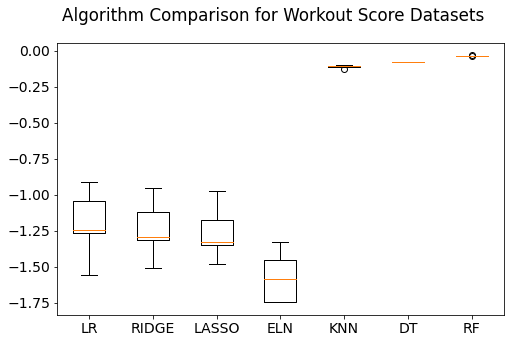

In [160]:
plt.rcParams.update({'figure.figsize': (8, 5)})
plt.rcParams.update({'font.size': 14})

# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison for Workout Score Datasets')
ax = fig.add_subplot(111)
plt.boxplot(results_sc)
ax.set_xticklabels(names)
plt.show()

In [161]:
model_sc = RandomForestRegressor(n_estimators = 100,
                                 n_jobs = -1,
                                 oob_score = True,
                                 bootstrap = True,
                                 random_state = 42)
model_sc.fit(X_train_preprocessed_sc, y_train_sc)

RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=42)

In [162]:
print('R^2 Training Score: {:.4f} \nOOB Score: {:.4f} \nR^2 Validation Score: {:.4f}'.format(model_sc.score(X_train_preprocessed_sc, y_train_sc), 
                                                                                             model_sc.oob_score_,
                                                                                             model_sc.score(X_test_preprocessed_sc, y_test_sc)))

R^2 Training Score: 0.9996 
OOB Score: 0.9972 
R^2 Validation Score: 0.9971


model is good enough!

In [163]:
importance_sc = model_sc.feature_importances_

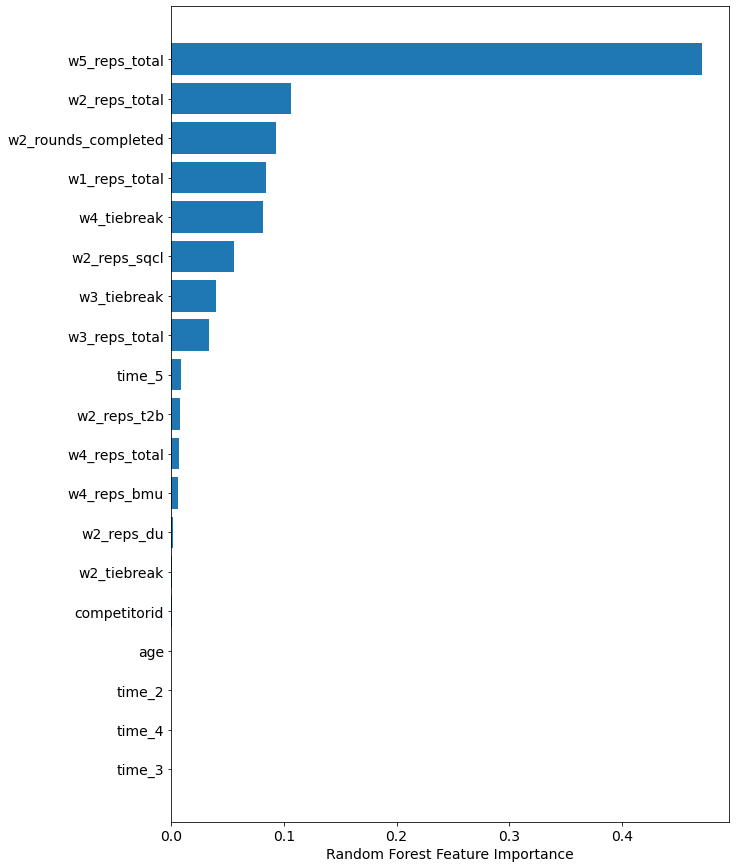

In [164]:
plt.rcParams.update({'figure.figsize': (10.0, 15.0)})
plt.rcParams.update({'font.size': 14})

sorted_idx = importance_sc.argsort()
plt.barh(X_sc.columns[sorted_idx], importance_sc[sorted_idx])
plt.xlabel("Random Forest Feature Importance");

#### benchmarks

In [165]:
model_bs = RandomForestRegressor(n_estimators = 100,
                                 n_jobs = -1,
                                 oob_score = True,
                                 bootstrap = True,
                                 random_state = 42)
model_bs.fit(X_train_preprocessed_bs, y_train_bs)

RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=42)

In [166]:
print('R^2 Training Score: {:.4f} \nOOB Score: {:.4f} \nR^2 Validation Score: {:.4f}'.format(model_bs.score(X_train_preprocessed_bs, y_train_bs), 
                                                                                             model_bs.oob_score_,
                                                                                             model_bs.score(X_test_preprocessed_bs, y_test_bs)))

R^2 Training Score: 0.9866 
OOB Score: 0.9108 
R^2 Validation Score: 0.9613


In [167]:
# Defining parameter grid (as dictionary)
param_grid = {"max_depth" : [25,30,35],
              #"max_features" : [20],
              #"max_leaf_nodes" : [230],
              #"max_samples" : [None],
              #"min_impurity_decrease" : [0.5],
              #"min_impurity_split" : [10],
              #"min_samples_leaf" : [1],
              #"min_samples_split" : [2],
              #"min_weight_fraction_leaf" : [0.00000000001],
              "n_estimators" : [100]
             }
scoring = 'neg_mean_absolute_percentage_error'
# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(model, param_grid, cv=5, verbose=5, n_jobs=-1, scoring=scoring)

In [168]:
gs.fit(X_train_preprocessed_bs, y_train_bs)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [25, 30, 35], 'n_estimators': [100]},
             scoring='neg_mean_absolute_percentage_error', verbose=5)

In [169]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",gs.best_estimator_)
print("\n The best score across ALL searched params:\n",gs.best_score_)
print("\n The best parameters across ALL searched params:\n",gs.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=25)

 The best score across ALL searched params:
 -0.8273437654654874

 The best parameters across ALL searched params:
 {'max_depth': 25, 'n_estimators': 100}


In [170]:
model_bs = RandomForestRegressor(
    max_depth = 30,
    n_estimators = 100,
    n_jobs = -1,
    oob_score = True,
    bootstrap = True,
    random_state = 42
)
model_bs.fit(X_train_preprocessed_bs, y_train_bs)

RandomForestRegressor(max_depth=30, n_jobs=-1, oob_score=True, random_state=42)

In [171]:
print('R^2 Training Score: {:.4f} \nOOB Score: {:.4f} \nR^2 Validation Score: {:.4f}'.format(model_bs.score(X_train_preprocessed_bs, y_train_bs), 
                                                                                             model_bs.oob_score_,
                                                                                             model_bs.score(X_test_preprocessed_bs, y_test_bs)))

R^2 Training Score: 0.9866 
OOB Score: 0.9108 
R^2 Validation Score: 0.9613


In [172]:
importance_bs = model_bs.feature_importances_

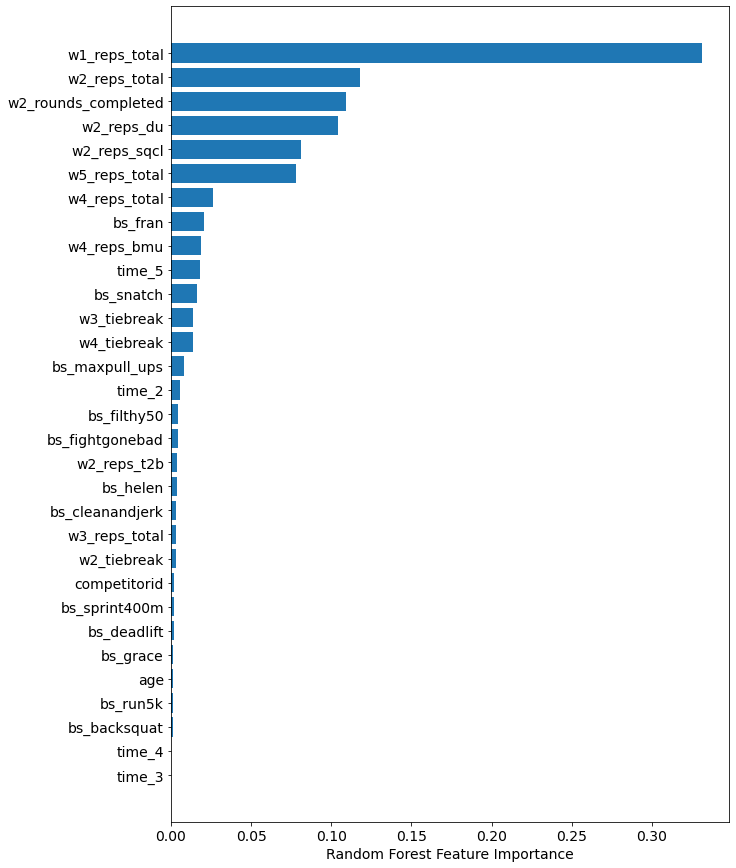

In [173]:
plt.rcParams.update({'figure.figsize': (10.0, 15.0)})
plt.rcParams.update({'font.size': 14})

sorted_idx = importance_bs.argsort()
plt.barh(X_bs.columns[sorted_idx], importance_bs[sorted_idx])
plt.xlabel("Random Forest Feature Importance");

## Sensitivities

### Scores

In [174]:
X_train_sc.columns

Index(['competitorid', 'age', 'time_2', 'time_3', 'time_4', 'time_5',
       'w1_reps_total', 'w2_reps_total', 'w2_reps_t2b', 'w2_reps_du',
       'w2_reps_sqcl', 'w2_rounds_completed', 'w2_tiebreak', 'w3_reps_total',
       'w3_tiebreak', 'w4_reps_total', 'w4_reps_bmu', 'w4_tiebreak',
       'w5_reps_total'],
      dtype='object')

In [175]:
features_sc = ['competitorid', 'age', 'time_2', 'time_3', 'time_4', 'time_5',
       'w1_reps_total', 'w2_reps_total', 'w2_reps_t2b', 'w2_reps_du',
       'w2_reps_sqcl', 'w2_rounds_completed', 'w2_tiebreak', 'w3_reps_total',
       'w3_tiebreak', 'w4_reps_total', 'w4_reps_bmu', 'w4_tiebreak',
       'w5_reps_total']

In [187]:
my_list = [0]*len(features_sc)
my_array = np.asarray([my_list])
result = model_sc.predict(my_array)
rank_ref = result[0]

list_pos_1 = []
list_pos_2 = []
list_pos_2_add = []
list_neg_1 = []
list_neg_2 = []
list_neg_2_add = []

for i in range(len(features_sc)):
    
    my_list[i] = 0.1
    my_array = np.asarray([my_list])
    result = model_sc.predict(my_array)
    a = round(((rank_ref - result[0])*100 / rank_ref),1)
    list_pos_1.append(a)
    my_list = [0]*len(features_sc)
    
    my_list[i] = 0.2
    my_array = np.asarray([my_list])
    result = model_sc.predict(my_array)
    b = round(((rank_ref - result[0])*100 / rank_ref),1)
    list_pos_2.append(b)
    list_pos_2_add.append(b-a)
    my_list = [0]*len(features_sc)
    
    my_list[i] = -0.1
    my_array = np.asarray([my_list])
    result = model_sc.predict(my_array)
    c = round(((rank_ref - result[0])*100 / rank_ref),1)
    list_neg_1.append(c)
    my_list = [0]*len(features_sc)
    
    my_list[i] = -0.2
    my_array = np.asarray([my_list])
    result = model_sc.predict(my_array)
    d = round(((rank_ref - result[0])*100 / rank_ref),1)
    list_neg_2.append(d)
    list_neg_2_add.append(d-c)
    my_list = [0]*len(features_sc)
    
df_sens_sc = pd.DataFrame(index=features_sc,data=list(zip(list_pos_1,list_pos_2_add,list_neg_1,list_neg_2_add)),columns=['+0.5 sigma','+1 sigma','-0.5 sigma','-1 sigma'])

In [188]:
df_sens_sc_ordered = df_sens_sc.sort_values(by='-0.5 sigma',ascending=False)
df_sens_sc_ordered

,+0.5 sigma,+1 sigma,-0.5 sigma,-1 sigma
w4_tiebreak,0.0,0.0,0.3,0.3
w3_tiebreak,-0.1,-0.2,0.1,0.0
time_2,0.0,0.0,0.0,0.0
time_3,0.0,0.0,0.0,0.0
time_4,0.0,0.0,0.0,0.0
time_5,0.0,0.0,0.0,0.0
w2_reps_t2b,0.0,0.0,0.0,0.0
competitorid,0.0,-0.1,-0.1,-0.1
age,0.0,0.2,-0.1,0.0
w2_reps_sqcl,0.0,3.4,-0.1,-0.6


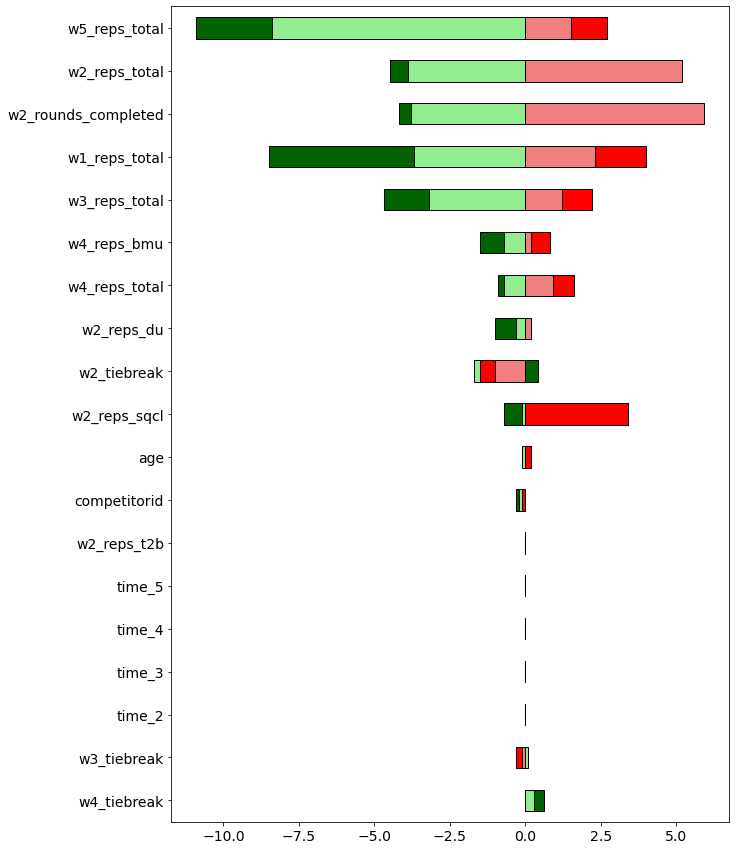

In [189]:
sens_colors = ['lightcoral','red','lightgreen','darkgreen']
df_sens_sc_ordered.plot.barh(stacked=True, edgecolor='black', color=sens_colors, legend=False);

### + benchmark statistics

In [190]:
X_train_bs.columns

Index(['competitorid', 'age', 'time_2', 'time_3', 'time_4', 'time_5',
       'w1_reps_total', 'w2_reps_total', 'w2_reps_t2b', 'w2_reps_du',
       'w2_reps_sqcl', 'w2_rounds_completed', 'w2_tiebreak', 'w3_reps_total',
       'w3_tiebreak', 'w4_reps_total', 'w4_reps_bmu', 'w4_tiebreak',
       'w5_reps_total', 'bs_backsquat', 'bs_cleanandjerk', 'bs_snatch',
       'bs_deadlift', 'bs_fightgonebad', 'bs_maxpull_ups', 'bs_fran',
       'bs_grace', 'bs_helen', 'bs_filthy50', 'bs_sprint400m', 'bs_run5k'],
      dtype='object')

In [191]:
features_bs = ['competitorid', 'age', 'time_2', 'time_3', 'time_4', 'time_5',
       'w1_reps_total', 'w2_reps_total', 'w2_reps_t2b', 'w2_reps_du',
       'w2_reps_sqcl', 'w2_rounds_completed', 'w2_tiebreak', 'w3_reps_total',
       'w3_tiebreak', 'w4_reps_total', 'w4_reps_bmu', 'w4_tiebreak',
       'w5_reps_total', 'bs_backsquat', 'bs_cleanandjerk', 'bs_snatch',
       'bs_deadlift', 'bs_fightgonebad', 'bs_maxpull_ups', 'bs_fran',
       'bs_grace', 'bs_helen', 'bs_filthy50', 'bs_sprint400m', 'bs_run5k']

In [192]:
my_list = [0]*len(features_bs)
my_array = np.asarray([my_list])
result = model_bs.predict(my_array)
rank_ref = result[0]

list_pos_1 = []
list_pos_2 = []
list_pos_2_add = []
list_neg_1 = []
list_neg_2 = []
list_neg_2_add = []

for i in range(len(features_bs)):
    
    my_list[i] = 0.1
    my_array = np.asarray([my_list])
    result = model_bs.predict(my_array)
    a = round(((rank_ref - result[0])*100 / rank_ref),1)
    list_pos_1.append(a)
    my_list = [0]*len(features_bs)
    
    my_list[i] = 0.2
    my_array = np.asarray([my_list])
    result = model_bs.predict(my_array)
    b = round(((rank_ref - result[0])*100 / rank_ref),1)
    list_pos_2.append(b)
    list_pos_2_add.append(b-a)
    my_list = [0]*len(features_bs)
    
    my_list[i] = -0.1
    my_array = np.asarray([my_list])
    result = model_bs.predict(my_array)
    c = round(((rank_ref - result[0])*100 / rank_ref),1)
    list_neg_1.append(c)
    my_list = [0]*len(features_bs)
    
    my_list[i] = -0.2
    my_array = np.asarray([my_list])
    result = model_bs.predict(my_array)
    d = round(((rank_ref - result[0])*100 / rank_ref),1)
    list_neg_2.append(d)
    list_neg_2_add.append(d-c)
    my_list = [0]*len(features_bs)
    
df_sens_bs = pd.DataFrame(index=features_bs,data=list(zip(list_pos_1,list_pos_2_add,list_neg_1,list_neg_2_add)),columns=['+0.5 sigma','+1 sigma','-0.5 sigma','-1 sigma'])

In [197]:
sens_bs_cols = ['bs_backsquat', 'bs_cleanandjerk', 'bs_snatch',
       'bs_deadlift', 'bs_fightgonebad', 'bs_maxpull_ups', 'bs_fran',
       'bs_grace', 'bs_helen', 'bs_filthy50', 'bs_sprint400m', 'bs_run5k']
df_sens_bs_filtered = df_sens_bs.loc[sens_bs_cols]
df_sens_bs_ordered = df_sens_bs_filtered.sort_values(by='-0.5 sigma',ascending=False)
df_sens_bs_ordered

,+0.5 sigma,+1 sigma,-0.5 sigma,-1 sigma
bs_backsquat,-0.3,0.0,0.2,0.0
bs_helen,0.0,-0.1,0.1,0.1
bs_run5k,-0.0,0.0,0.1,-0.2
bs_deadlift,-0.1,0.0,0.0,0.7
bs_fightgonebad,0.0,0.0,0.0,-0.5
bs_maxpull_ups,-0.1,0.0,0.0,0.1
bs_fran,0.1,0.4,-0.0,0.0
bs_grace,0.0,-0.1,-0.0,0.0
bs_filthy50,-0.5,0.0,0.0,0.0
bs_sprint400m,0.0,0.5,0.0,-0.1


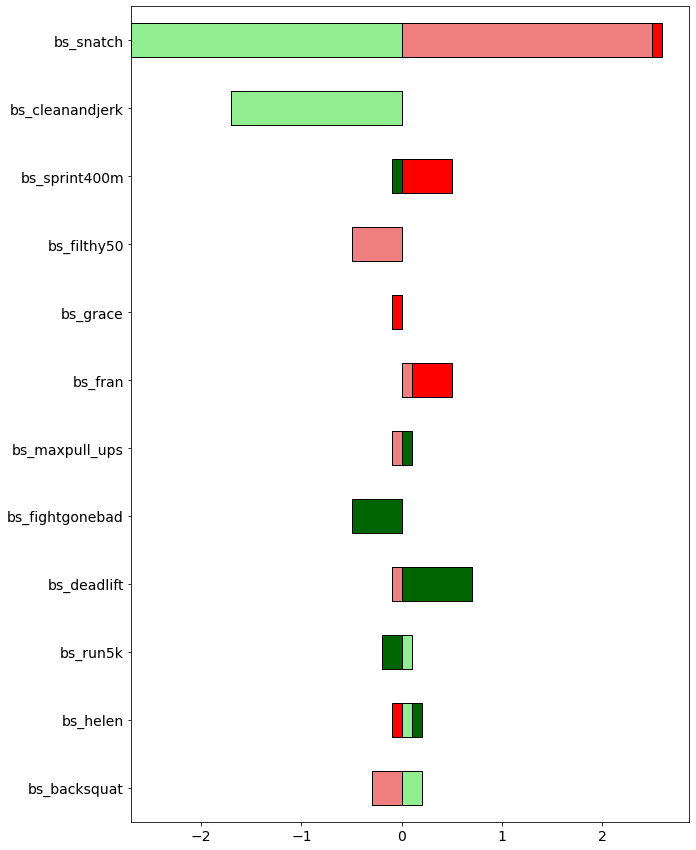

In [198]:
sens_colors = ['lightcoral','red','lightgreen','darkgreen']
df_sens_bs_ordered.plot.barh(stacked=True, edgecolor='black', color=sens_colors, legend=False);